In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/store-sales-time-series-forecasting/oil.csv
/kaggle/input/store-sales-time-series-forecasting/sample_submission.csv
/kaggle/input/store-sales-time-series-forecasting/holidays_events.csv
/kaggle/input/store-sales-time-series-forecasting/stores.csv
/kaggle/input/store-sales-time-series-forecasting/train.csv
/kaggle/input/store-sales-time-series-forecasting/test.csv
/kaggle/input/store-sales-time-series-forecasting/transactions.csv


# Importing the necessary dependencies first

In [2]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import warnings 
#importing the statsmodel library and the required functions for the SARIMAX model
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from statsmodels.tsa.api import acf, pacf, graphics
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.dates as mpl_dates
from keras.models import Model, Sequential
from keras.layers import GRU, Dense
from keras.callbacks import EarlyStopping


In [3]:
holidays=pd.read_csv('../input/store-sales-time-series-forecasting/holidays_events.csv')

In [4]:
holidays.head(5)

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [5]:
oil=pd.read_csv('../input/store-sales-time-series-forecasting/oil.csv')

In [6]:
oil.head(5)

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20


In [7]:
stores=pd.read_csv('../input/store-sales-time-series-forecasting/stores.csv')

In [8]:
stores.head(5)

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [9]:
transactions=pd.read_csv('../input/store-sales-time-series-forecasting/transactions.csv')

In [10]:
transactions.head(5)

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922


In [11]:
train_data=pd.read_csv('../input/store-sales-time-series-forecasting/train.csv')
train_data.head(5)

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [12]:
test_data=pd.read_csv('../input/store-sales-time-series-forecasting/test.csv')
test_data.head(5)

,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0
1,3000889,2017-08-16,1,BABY CARE,0
2,3000890,2017-08-16,1,BEAUTY,2
3,3000891,2017-08-16,1,BEVERAGES,20
4,3000892,2017-08-16,1,BOOKS,0


# Checking for Null values 


In [13]:
 pd.DataFrame(data = 
              [holidays.isna().sum()/holidays.shape[0]*100,
              oil.isna().sum()/oil.shape[0]*100,
              stores.isna().sum()/stores.shape[0]*100,
              transactions.isna().sum()/transactions.shape[0]*100,
              train_data.isna().sum()/train_data.shape[0]*100,
              test_data.isna().sum()/test_data.shape[0]*100],
              index=["Holidays Null (%)", "Oil Null (%)","Stores Null (%)", "Transactions Null (%)","Train Null (%)", "Test Null (%)"]).T.style.background_gradient(cmap='summer_r')

,Holidays Null (%),Oil Null (%),Stores Null (%),Transactions Null (%),Train Null (%),Test Null (%)
date,0.000000,0.000000,nan,0.000000,0.000000,0.000000
type,0.000000,nan,0.000000,nan,nan,nan
locale,0.000000,nan,nan,nan,nan,nan
locale_name,0.000000,nan,nan,nan,nan,nan
description,0.000000,nan,nan,nan,nan,nan
transferred,0.000000,nan,nan,nan,nan,nan
dcoilwtico,nan,3.530378,nan,nan,nan,nan
store_nbr,nan,nan,0.000000,0.000000,0.000000,0.000000
city,nan,nan,0.000000,nan,nan,nan
state,nan,nan,0.000000,nan,nan,nan


Most important thing to note down here is the fact that oil is missing 3.53% of its values here

**Since the amount of missing values is very less, we can drop them**

In [14]:
oil = oil.dropna ()
oil.count ()

date          1175
dcoilwtico    1175
dtype: int64

**Transforming the Date(s) into date series format. This is an import step as its the only format in which we can process this data**

In [15]:
holidays['date']=pd.to_datetime(holidays['date'])
oil['date']=pd.to_datetime(oil['date'])
transactions['date']=pd.to_datetime(transactions['date'])


**Some statistical analysis on the categorical datasets**

In [16]:
holidays.describe(include=[object])

,type,locale,locale_name,description
count,350,350,350,350
unique,6,3,24,103
top,Holiday,National,Ecuador,Carnaval
freq,221,174,174,10


In [17]:
stores.describe(include=[object])

,city,state,type
count,54,54,54
unique,22,16,5
top,Quito,Pichincha,D
freq,18,19,18


# Creating Lag plots for the datasets 
Purpose of lag plots is to notice if there are any trends/randomness in our datasets. <br>
We want the data to be as stationary as possible for our model <br>
*note: t+1 represents the moving average.*

In [18]:
warnings.filterwarnings ("ignore")

In [19]:
from pandas.plotting import lag_plot
sns.set(style='darkgrid')

<AxesSubplot:xlabel='y(t)', ylabel='y(t + 1)'>

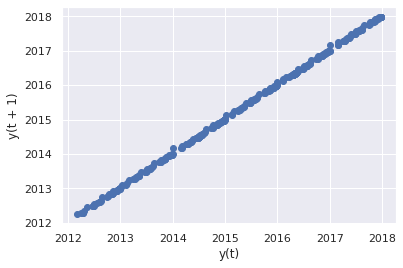

In [20]:
#Lag_plot for holidays dataset
lag_plot(holidays['date'])

<AxesSubplot:xlabel='y(t)', ylabel='y(t + 1)'>

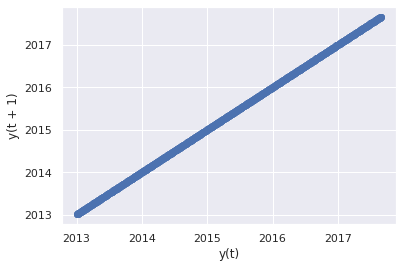

In [21]:
lag_plot (oil ['date'])

<AxesSubplot:xlabel='y(t)', ylabel='y(t + 1)'>

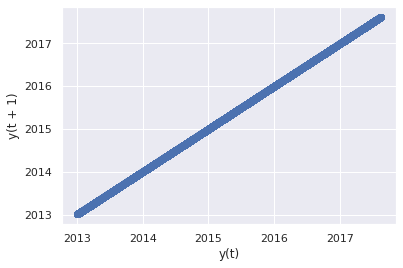

In [22]:
lag_plot (transactions ['date'])

## Calculating the Autocorrelation and Partial Autocorrelation
Calculating the Autoregressive and visualizing the autocorrelation between the assumed value and the previous value allows us to check the randomness in the time series. 

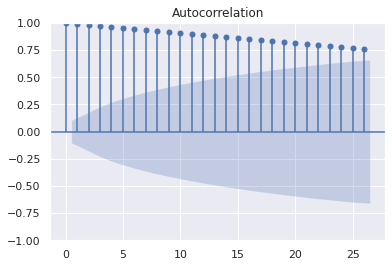

In [23]:
#plotting acf -autocorrelation curve on holiday dataset
from statsmodels.graphics.tsaplots import plot_acf
plot_acf (holidays ['date'])
plt.show ()


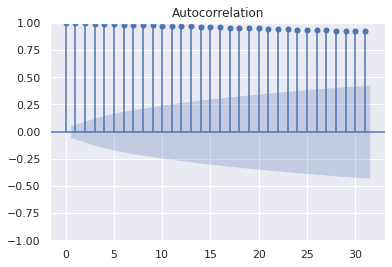

In [24]:
#plotting acf -autocorrelation curve on oil dataset
plot_acf(oil['date'])
plt.show()

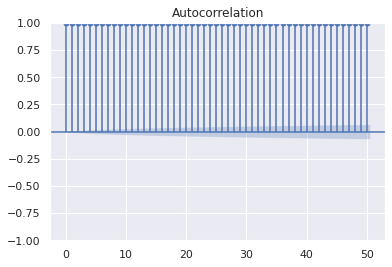

In [25]:
# #plotting acf -autocorrelation curve on transactions data set
plot_acf (transactions ['date'])
plt.show ()

**Plotting the Partial Autocorrelation curves now**

In [26]:
from statsmodels.graphics.tsaplots import plot_pacf

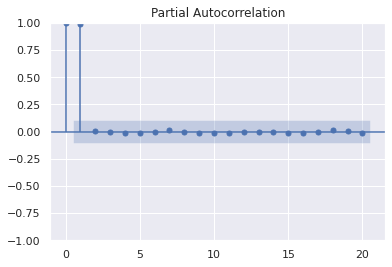

In [27]:
#plotting pacf - partial autocorrelation curve on holiday dataset
plot_pacf (holidays ['date'], lags = 20)
plt.show ()

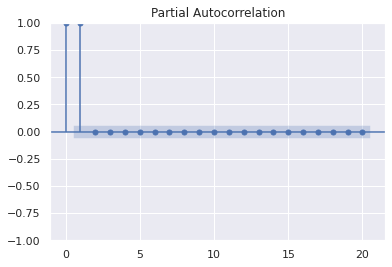

In [28]:
#plotting pacf - partial autocorrelation curve on oil dataset
plot_pacf (oil ['date'], lags = 20)
plt.show ()

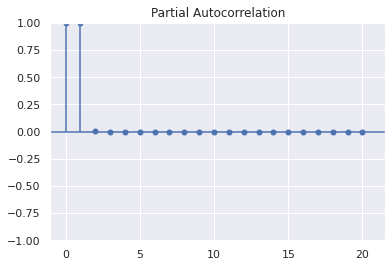

In [29]:
#plotting pacf - partial autocorrelation curve on transaction dataset
plot_pacf (transactions ['date'], lags = 20)
plt.show ()

**Vizualizing the Autocorrelation models**

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

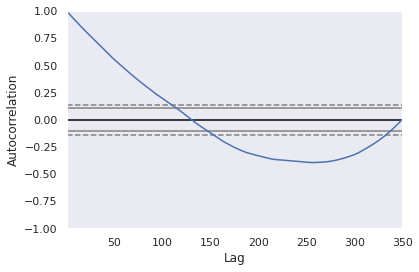

In [30]:
#Importing the functions
from pandas.plotting import autocorrelation_plot
sns.set ()
#Visualizing Holidays dataset autocorrelation 
holidays.reset_index(inplace=True)
holidays['date']=holidays['date'].apply(mpl_dates.date2num)
holidays['date']=holidays['date'].astype(float)
autocorrelation_plot(holidays['date'])

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

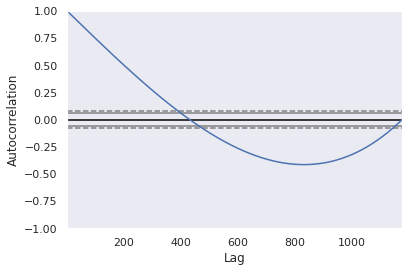

In [31]:
# Visualizing Oil dataset autocorrelation 
oil.reset_index(inplace=True)
oil['date']=oil['date'].apply(mpl_dates.date2num)
oil['date']=oil['date'].astype(float)
autocorrelation_plot(oil['date'])


<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

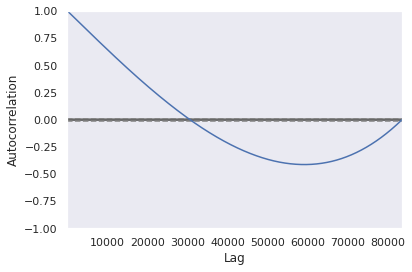

In [32]:
# Visualizing Oil dataset autocorrelation 
transactions.reset_index(inplace=True)
transactions['date']=transactions['date'].apply(mpl_dates.date2num)
transactions['date']=transactions['date'].astype(float)
autocorrelation_plot(transactions['date'])

**Autoregression Modelling --> It is a time series model that uses observations from previous time steps as input to a regression equation to predict the value at the next time step.**

In [33]:
# Apply AutoRreg model for holidays dataset
# aic is the best way to evaluate this model
modelH = AutoReg (holidays ['date'], 1)
resultsH = modelH.fit ()
resultsH.aic

2553.559002153026

In [34]:
# Apply AutoRreg model for oil dataset
modelO = AutoReg (oil['date'], 1)
resultsO = modelO.fit ()
resultsO.aic

3039.3076040432716

In [35]:
# Apply AutoRreg model for transactions dataset
modelT = AutoReg (transactions['date'], 1)
resultsT = modelT.fit ()
resultsT.aic


-89918.13458171782

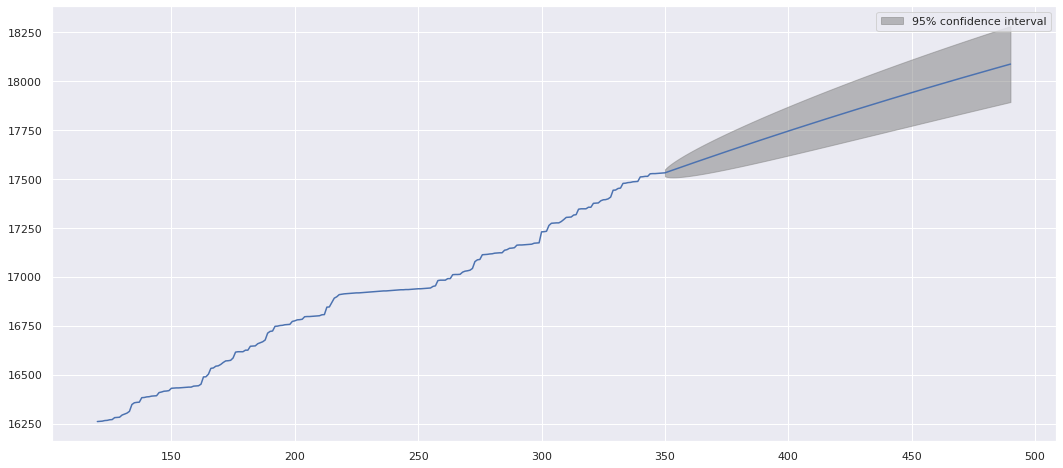

In [36]:
# default figure size
pd.plotting.register_matplotlib_converters ()
sns.mpl.rc ('figure', figsize = (18, 8))

# use plot_predict and visualize forecasts for holiday dataset
figure = resultsH.plot_predict (120, 490)

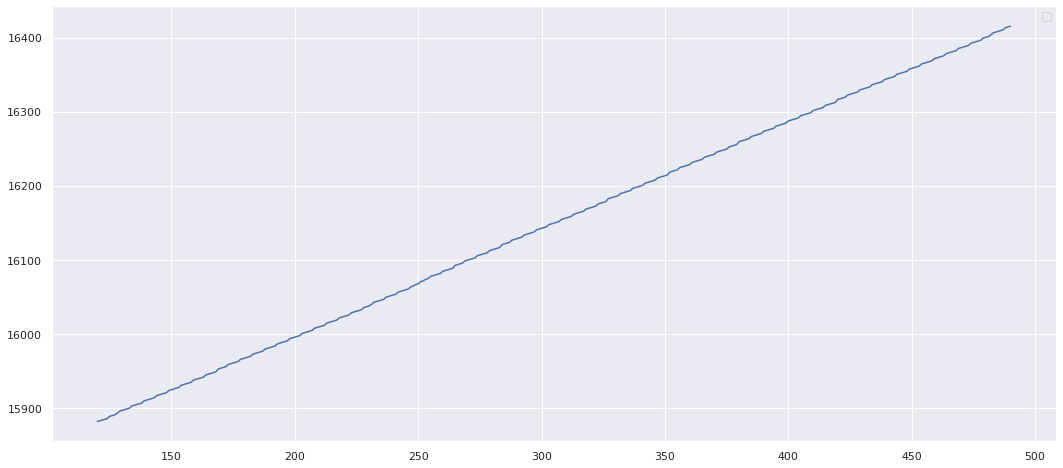

In [37]:
# use plot_predict and visualize forecasts for oil dataset
figure = resultsO.plot_predict (120, 490)

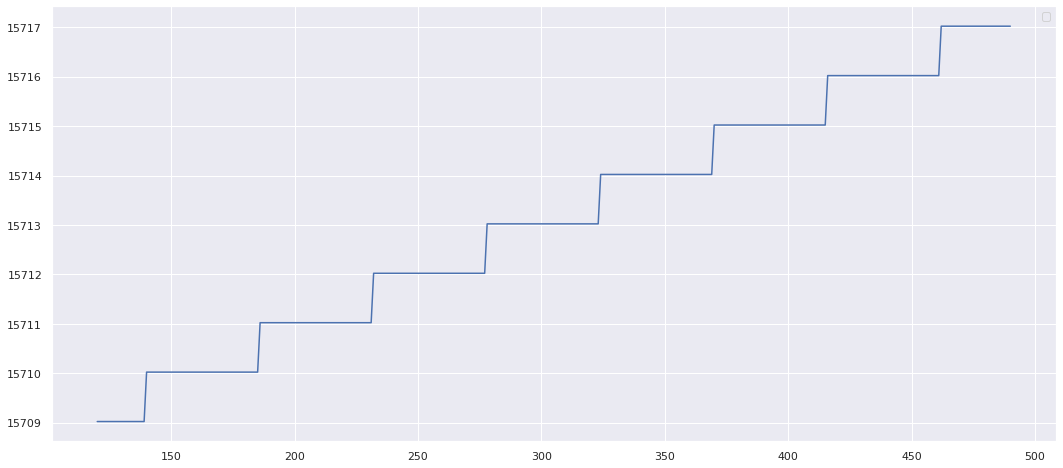

In [38]:
# use plot_predict and visualize forecasts for oil dataset
figure = resultsT.plot_predict (120, 490)

## Predicting using the model's forcast function

**Now I can split all these datasets into training and testing sets.After applying Appropriate scaling and processing, I can forcast results using the autoreg model predict function. I am going to do it for only one of the datasets. <br>
i.e the oil dataset**


In [39]:
from sklearn.model_selection import train_test_split
# create train set containing only the model features
X = oil

X_train, X_test = train_test_split(X, test_size=0.15, random_state=42)

print ('Training data shape X: ', X_train.shape)
print ('Test data shape X: ', X_test.shape)

Training data shape X:  (998, 3)
Test data shape X:  (177, 3)


In [40]:
# scale train data to be in range (0, 1)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler ()
X_train = scaler.fit_transform (X_train)

# scale test data to be in range (0, 1)
X_test = scaler.transform (X_test)

In [41]:
# specify the number of steps to forecast ahead
steps = 177
print ('Forecasting : ', steps, 'days')

Forecasting :  177 days


In [42]:
training_window = 998

history = [x for x in X_train]
history = history [(-training_window):]
predictions = list ()

for t in range (X_test.shape [0]):
    modelO = AutoReg (oil ['date'], 1)
    modelO_fit = modelO.fit ()
    preds = modelO_fit.forecast(steps)
    predictions.append (preds)
    obs = list (X_test [t])
    # move the training window
    history.append (obs [0])
    history.pop (0)
    print (X_test [t])
    print (t+1, ': predicted =', preds, 'expected =', obs)

[ 0.20712185  0.20794102 -0.97802257]
1 : predicted = 1175    17410.449601
1176    17411.899201
1177    17413.348801
1178    17414.798401
1179    17416.248000
            ...     
1347    17659.777257
1348    17661.226816
1349    17662.676374
1350    17664.125931
1351    17665.575489
Length: 177, dtype: float64 expected = [0.20712185448125617, 0.20794101702337434, -0.9780225706442204]
[-0.47806233 -0.47966358  0.96773264]
2 : predicted = 1175    17410.449601
1176    17411.899201
1177    17413.348801
1178    17414.798401
1179    17416.248000
            ...     
1347    17659.777257
1348    17661.226816
1349    17662.676374
1350    17664.125931
1351    17665.575489
Length: 177, dtype: float64 expected = [-0.4780623306913304, -0.47966358168414636, 0.9677326399957993]
[-1.1689092  -1.16726818  1.39493575]
3 : predicted = 1175    17410.449601
1176    17411.899201
1177    17413.348801
1178    17414.798401
1179    17416.248000
            ...     
1347    17659.777257
1348    17661.226816
13

# Deep Learning for Time Series Forcasting
**Using A RNN Model**

In [43]:
X = train_data
Y = test_data
# Note: They have already been loaded initially 


In [44]:
#Sampling the data for faster optimization and training of the model
X=X['date'].sample(5000)
Y=Y['date'].sample(5000)

#converting the datasets to time series format 

X=pd.to_datetime(X)
Y=pd.to_datetime(Y)

In [45]:
# Setting up the number of lag variable
T = 1
#Setting up the steps. Since we just want to predict the outcome of the next day
steps = 1


In [46]:
#Splitting up the train and test sets with only the features
x_train , y_train , x_test , y_test = train_test_split(X,Y,test_size=0.5,random_state=42)

In [47]:
print ('Training data shape X: ', x_train.shape)
print ('Test data shape X: ', x_test.shape)
print ('Training data shape y: ', y_train.shape)
print ('Test data shape y: ', y_test.shape)

Training data shape X:  (2500,)
Test data shape X:  (2500,)
Training data shape y:  (2500,)
Test data shape y:  (2500,)


In [48]:
#Creating a validation set for our DL model
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, train_size=0.5)
print ('Validation data shape X: ', x_valid.shape)
print ('Validation data shape y: ', y_valid.shape)

Validation data shape X:  (1250,)
Validation data shape y:  (1250,)


In [49]:
#Converting the data to NumPy array 
x_train = np.asarray(x_train).astype(np.float32)
y_train = np.asarray(y_train).astype(np.float32)
x_test = np.asarray(x_test).astype(np.float32)
y_test = np.asarray(y_test).astype(np.float32)
x_valid = np.asarray (x_valid).astype (np.float32)
y_valid = np.asarray (y_valid).astype (np.float32)

In [50]:
#Rescaling all the features
from sklearn.preprocessing import MinMaxScaler
# scaler=StandardScaler() # this is giving me a very high loss rate
scaler=MinMaxScaler()
x_train = scaler.fit_transform(x_train.reshape(-1, 1))
y_train = scaler.fit_transform(y_train.reshape(-1, 1)) 
x_test = scaler.fit_transform(x_test.reshape(-1, 1))
y_test = scaler.fit_transform(y_test.reshape(-1, 1))
x_valid = scaler.fit_transform(x_valid.reshape(-1, 1))
y_valid = scaler.fit_transform(y_valid.reshape(-1, 1))

In [51]:
#Reshaping the data to include the lag variable 
x_train = np.reshape(x_train, (x_train.shape[0], T, x_train.shape[1]))
y_train = np.reshape(y_train, (y_train.shape[0], T, y_train.shape[1]))
x_test = np.reshape(x_test, (x_test.shape[0], T, x_test.shape[1]))
y_test = np.reshape(y_test, (y_test.shape[0], T, y_test.shape[1]))
x_valid = np.reshape(x_valid, (x_valid.shape[0], T, x_valid.shape[1]))
y_valid = np.reshape(y_valid, (y_valid.shape[0], T, y_valid.shape[1]))

In [52]:
x_train.shape

(1250, 1, 1)

In [53]:
#Defining parameters for my RNN model

LATENT_DIM=5 #Number of units in the RNN Layer

BATCH_size= 25 #Number of samples per mini batch 

EPOCHS = 15 # maximum number of times the training algorithm will cycle through all samples

#Define the sequential model
model=Sequential()
model.add(GRU(LATENT_DIM,input_shape=(T,1)))
model.add(Dense(steps))

model.compile(optimizer='RMSprop',loss='mse')
model.summary()

2022-08-21 14:50:11.862465: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 5)                 120       
_________________________________________________________________
dense (Dense)                (None, 1)                 6         
Total params: 126
Trainable params: 126
Non-trainable params: 0
_________________________________________________________________


In [54]:
# specify early stop criteria
GRU_earlystop = EarlyStopping (monitor = 'val_loss', min_delta = 0, patience = 5)

#fit our model with the data
history = model.fit(x_train,y_train,batch_size=BATCH_size,epochs=EPOCHS,validation_data=(x_valid,y_valid),callbacks=[GRU_earlystop])

Epoch 1/15


2022-08-21 14:50:12.342707: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


50/50 [==============================] - 3s 14ms/step - loss: 0.2085 - val_loss: 0.1346
Epoch 2/15
50/50 [==============================] - 0s 3ms/step - loss: 0.1101 - val_loss: 0.0895
Epoch 3/15
50/50 [==============================] - 0s 3ms/step - loss: 0.0906 - val_loss: 0.0866
Epoch 4/15
50/50 [==============================] - 0s 4ms/step - loss: 0.0882 - val_loss: 0.0856
Epoch 5/15
50/50 [==============================] - 0s 3ms/step - loss: 0.0869 - val_loss: 0.0836
Epoch 6/15
50/50 [==============================] - 0s 4ms/step - loss: 0.0859 - val_loss: 0.0842
Epoch 7/15
50/50 [==============================] - 0s 4ms/step - loss: 0.0853 - val_loss: 0.0824
Epoch 8/15
50/50 [==============================] - 0s 4ms/step - loss: 0.0853 - val_loss: 0.0824
Epoch 9/15
50/50 [==============================] - 0s 3ms/step - loss: 0.0851 - val_loss: 0.0824
Epoch 10/15
50/50 [==============================] - 0s 4ms/step - loss: 0.0850 - val_loss: 0.0818
Epoch 11/15
50/50 [==========

**Visualizing Train Loss, Val Loss and Epochs**


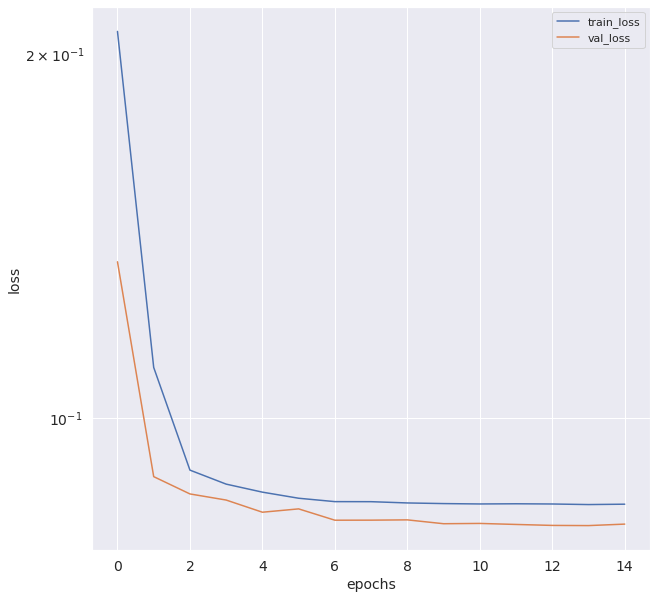

In [55]:
plot_loss=pd.DataFrame.from_dict({'train_loss':history.history['loss'],'val_loss':history.history['val_loss']})
plot_loss.plot(logy=True,figsize=(10,10),fontsize=14)
plt.xlabel('epochs', fontsize=14)
plt.ylabel('loss', fontsize=14)
plt.show()

**LOSS Decreases with the number of Epochs**

#### Now we make predictions on the x_test dataset and compare them with y_yesy dataset

In [56]:
test_preds=model.predict(x_test)
test_preds_df=pd.DataFrame(test_preds)
test_preds_df["predictions"]=pd.DataFrame(test_preds)
test_preds_df["actual"]=np.transpose (y_test).ravel ()


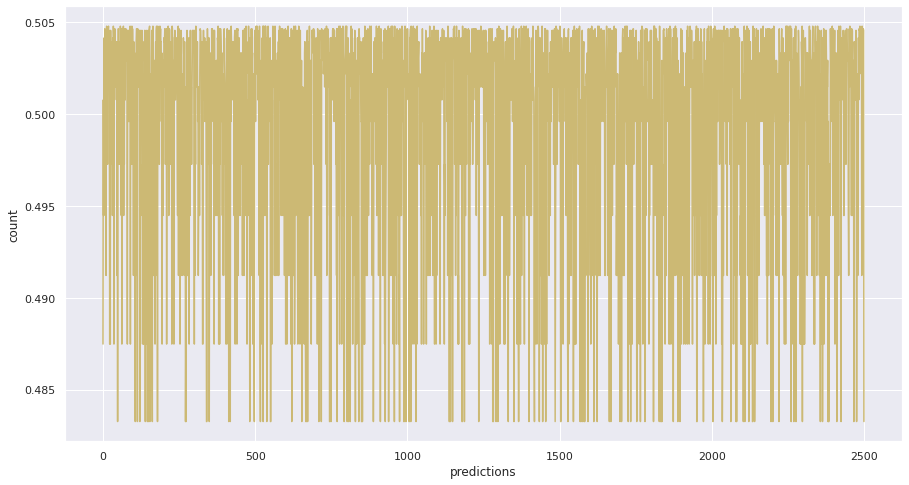

In [57]:
# plot the count of predictions
test_preds_df ['actual' < '0.3'].plot (x = 'predictions', style = ['y', 'b'], figsize = (15, 8))
plt.xlabel ('predictions', fontsize = 12)
plt.ylabel ('count', fontsize = 12)
plt.show ()

# Submit Test Predictions

In [58]:
final_prediction=pd.read_csv('../input/store-sales-time-series-forecasting/test.csv')
final_prediction_data=final_prediction['date']
xtest=pd.to_datetime(final_prediction_data)
xtest = np.asarray(xtest).astype(np.float32)
xtest = scaler.fit_transform(xtest.reshape(-1, 1))
xtest = np.reshape(xtest, (xtest.shape[0], T, xtest.shape[1]))

In [59]:
y_pred=model.predict(xtest)
submission=pd.read_csv('../input/store-sales-time-series-forecasting/sample_submission.csv')
submission['sales'] = y_pred
submission.to_csv('submission.csv', index=False)